In [1]:
import json
from preprocessor.preprocessor_pytorch import Preprocessor
from model.model_pytorch import Model
from postprocessor.postprocessor import Postprocesser
from evaluator.evaluator_pytorch import Evaluator
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    random.seed(seed_value)
    torch.manual_seed(seed_value)
set_seed(42)

with open('parameters.json', 'r') as file:
    params = json.load(file)

In [2]:
params

{'start_date': '2001-01-01',
 'stop_date': '2021-01-01',
 'stock_symbol': '^GSPC',
 'features_params': [{'type': 'Trend',
   'method': 'LocalExtrema',
   'oder_days': 20,
   'ma_days': 10,
   'trend_days': 5},
  {'type': 'MACD', 'fastperiod': 5, 'slowperiod': 10, 'signalperiod': 9},
  {'type': 'ROC', 'trend_days': 5},
  {'type': 'Stochastic Oscillator', 'trend_days': 5},
  {'type': 'CCI', 'timeperiod': 14},
  {'type': 'RSI', 'timeperiod': 14},
  {'type': 'VMA', 'timeperiod': 20},
  {'type': 'pctChange'},
  {'type': '3M Treasury Yield',
   'start_date': '2001-01-01',
   'end_date': '2021-01-01'},
  {'type': '5Y Treasury Yield',
   'start_date': '2001-01-01',
   'end_date': '2021-01-01'},
  {'type': '10Y Treasury Yield',
   'start_date': '2001-01-01',
   'end_date': '2021-01-01'},
  {'type': '30Y Treasury Yield',
   'start_date': '2001-01-01',
   'end_date': '2021-01-01'},
  {'type': 'Bollinger Bands', 'timeperiod': 20, 'nbdevup': 2, 'nbdevdn': 2},
  {'type': 'ATR', 'timeperiod': 14},
  

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import talib
from abc import ABC, abstractmethod
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch import from_numpy
import torch
from sklearn.model_selection import train_test_split
import tqdm

class FeatureBase(ABC):
    """
    Abstract base class for all features.
    """
    @abstractmethod
    def compute(self, data=None, *args, **kwargs):
        """
        Abstract method to compute the feature value for the given data.
        """
        pass


class IndicatorTrend(FeatureBase):
    """
    Indicator to calculate the trend based on various methods.
    """

    def compute(self, data, *args, **kwargs):
        """
        Compute the trend for the given data using the specified method.
        """
        method = kwargs.get('method', 'MA')
        ma_days = kwargs.get('ma_days', 20)
        oder_days = kwargs.get('oder_days', 20)
        trend_days = kwargs.get('trend_days', 5)

        if method == 'MA':
            return self.calculate_trend_MA(data, ma_days=ma_days, trend_days=trend_days)
        elif method == 'LocalExtrema':
            return self.calculate_trend_LocalExtrema(data, oder_days=oder_days)
        else:
            raise ValueError(f"Invalid trend calculation method: {method}")

    def calculate_trend_MA(self, data, ma_days=20, trend_days=5):
        """
        Calculate trend using Moving Average method.
        """
        data['MA'] = data['Close'].rolling(window=ma_days).mean()
        data['Trend'] = np.nan
        n = len(data)

        for i in range(n - trend_days + 1):
            if all(data['MA'].iloc[i + j] < data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
                data['Trend'].iloc[i:i + trend_days] = 0 # up trend
            elif all(data['MA'].iloc[i + j] > data['MA'].iloc[i + j + 1] for j in range(trend_days - 1)):
                data['Trend'].iloc[i:i + trend_days] = 1 # down trend
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['MA'])

    def calculate_trend_LocalExtrema(self, data, oder_days=20):
        """
        Calculate trend using Local Extrema method.
        """
        local_max_indices = argrelextrema(
            data['Close'].values, np.greater_equal, order=oder_days)[0]
        local_min_indices = argrelextrema(
            data['Close'].values, np.less_equal, order=oder_days)[0]
        data['Local Max'] = data.iloc[local_max_indices]['Close']
        data['Local Min'] = data.iloc[local_min_indices]['Close']
        data['Trend'] = np.nan
        prev_idx = None
        prev_trend = None
        prev_type = None

        for idx in sorted(np.concatenate([local_max_indices, local_min_indices])):
            if idx in local_max_indices:
                current_type = "max"
            else:
                current_type = "min"

            if prev_trend is None:
                if current_type == "max":
                    prev_trend = 1
                else:
                    prev_trend = 0
            else:
                if prev_type == "max" and current_type == "min":
                    data.loc[prev_idx:idx, 'Trend'] = 1
                    prev_trend = 1 # down trend
                elif prev_type == "min" and current_type == "max":
                    data.loc[prev_idx:idx, 'Trend'] = 0
                    prev_trend = 0 # up trend
                else:
                    if current_type == "max":
                        data.loc[prev_idx:idx, 'Trend'] = 0
                        prev_trend = 0 # up trend
                    else:
                        data.loc[prev_idx:idx, 'Trend'] = 1
                        prev_trend = 1 # down trend

            prev_idx = idx
            prev_type = current_type
        data['Trend'].fillna(method='ffill', inplace=True)
        return data.drop(columns=['Local Max', 'Local Min'])


class IndicatorMACD(FeatureBase):
    """
    Indicator to calculate the Moving Average Convergence Divergence (MACD).
    """

    def compute(self, data, *args, **kwargs):
        fastperiod = kwargs.get('fastperiod', 5)
        slowperiod = kwargs.get('slowperiod', 10)
        signalperiod = kwargs.get('signalperiod', 9)
        data['MACD'], _, _ = talib.MACD(
            data['Close'], fastperiod=fastperiod, slowperiod=slowperiod, signalperiod=signalperiod)
        return data


class IndicatorROC(FeatureBase):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['ROC'] = talib.ROC(data['Close'], timeperiod=trend_days)
        return data


class IndicatorStochasticOscillator(FeatureBase):
    def compute(self, data, *args, **kwargs):
        trend_days = kwargs.get('trend_days', 5)
        data['StoK'], data['StoD'] = talib.STOCH(
            data['High'], data['Low'], data['Close'], fastk_period=trend_days, slowk_period=3, slowd_period=3)
        return data


class IndicatorCCI(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['CCI'] = talib.CCI(data['High'], data['Low'],
                                data['Close'], timeperiod=timeperiod)
        return data


class IndicatorRSI(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['RSI'] = talib.RSI(data['Close'], timeperiod=timeperiod)
        return data


class IndicatorVMA(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 20)
        data['VMA'] = talib.MA(data['Volume'], timeperiod=timeperiod)
        return data


class IndicatorPctChange(FeatureBase):
    def compute(self, data, *args, **kwargs):
        data['pctChange'] = data['Close'].pct_change() * 100
        return data


class TreasuryYieldThreeMonth(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        three_month_treasury_yield = yf.download(
            "^IRX", start_date, end_date)["Close"]
        data['3M Treasury Yield'] = three_month_treasury_yield
        return data


class TreasuryYieldFiveYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        five_year_treasury_yield = yf.download(
            "^FVX", start_date, end_date)["Close"]
        data['5Y Treasury Yield'] = five_year_treasury_yield
        return data


class TreasuryYieldTenYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        ten_year_treasury_yield = yf.download(
            "^TNX", start_date, end_date)["Close"]
        data['10Y Treasury Yield'] = ten_year_treasury_yield
        return data


class TreasuryYieldThirtyYear(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start_date = kwargs.get('start_date')
        end_date = kwargs.get('end_date')
        thirty_year_treasury_yield = yf.download(
            "^TYX", start_date, end_date)["Close"]
        data['30Y Treasury Yield'] = thirty_year_treasury_yield
        return data
# Add other features here as needed

class IndicatorBollingerBands(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 20)
        nbdevup = kwargs.get('nbdevup', 2)
        nbdevdn = kwargs.get('nbdevdn', 2)
        data['upperband'], data['middleband'], data['lowerband'] = talib.BBANDS(
            data['Close'], timeperiod=timeperiod, nbdevup=nbdevup, nbdevdn=nbdevdn)
        return data

class IndicatorATR(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 14)
        data['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=timeperiod)
        return data

class IndicatorOBV(FeatureBase):
    def compute(self, data, *args, **kwargs):
        data['OBV'] = talib.OBV(data['Close'], data['Volume'])
        return data

# Placeholder for Fibonacci Retracements since it's more of a visual tool and not directly calculable through a simple function.
# You would typically use this by selecting significant price points (peaks and troughs) and then calculating the Fibonacci levels manually or through a graphical interface.

class IndicatorIchimokuCloud(FeatureBase):
    def compute(self, data, *args, **kwargs):
        high = data['High']
        low = data['Low']
        # Ichimoku parameters: 9 for Tenkan-sen, 26 for Kijun-sen, and 52 for Senkou Span B
        data['Tenkan-sen'] = (high.rolling(window=9).max() + low.rolling(window=9).min()) / 2
        data['Kijun-sen'] = (high.rolling(window=26).max() + low.rolling(window=26).min()) / 2
        data['Senkou Span A'] = ((data['Tenkan-sen'] + data['Kijun-sen']) / 2).shift(26)
        data['Senkou Span B'] = ((high.rolling(window=52).max() + low.rolling(window=52).min()) / 2).shift(26)
        data['Chikou Span'] = data['Close'].shift(-26)
        return data
    
class IndicatorParabolicSAR(FeatureBase):
    def compute(self, data, *args, **kwargs):
        start = kwargs.get('start', 0.02)
        increment = kwargs.get('increment', 0.02)
        maximum = kwargs.get('maximum', 0.2)
        data['Parabolic SAR'] = talib.SAR(data['High'], data['Low'], acceleration=start, maximum=maximum)
        return data

class IndicatorMOM(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 10)
        data['MOM'] = talib.MOM(data['Close'], timeperiod=timeperiod)
        return data

class IndicatorWilliamsR(FeatureBase):
    def compute(self, data, *args, **kwargs):
        lookback_period = kwargs.get('lookback_period', 14)
        data['Williams %R'] = talib.WILLR(data['High'], data['Low'], data['Close'], timeperiod=lookback_period)
        return data

class IndicatorChaikinMF(FeatureBase):
    def compute(self, data, *args, **kwargs):
        timeperiod = kwargs.get('timeperiod', 20)
        data['Chaikin MF'] = talib.ADOSC(data['High'], data['Low'], data['Close'], data['Volume'], fastperiod=3, slowperiod=timeperiod)
        return data
    
class FeatureFactory:
    """
    Factory class dedicated to creating various technical features.
    """
    @staticmethod
    def get_feature(feature_type):
        """
        Retrieve the desired feature based on the specified type.
        """
        features = {
            "Trend": IndicatorTrend,
            "MACD": IndicatorMACD,
            "ROC": IndicatorROC,
            "Stochastic Oscillator": IndicatorStochasticOscillator,
            "CCI": IndicatorCCI,
            "RSI": IndicatorRSI,
            "VMA": IndicatorVMA,
            "pctChange": IndicatorPctChange,
            "3M Treasury Yield": TreasuryYieldThreeMonth,
            "5Y Treasury Yield": TreasuryYieldFiveYear,
            "10Y Treasury Yield": TreasuryYieldTenYear,
            "30Y Treasury Yield": TreasuryYieldThirtyYear,
            "Bollinger Bands": IndicatorBollingerBands,
            "ATR": IndicatorATR,
            "OBV": IndicatorOBV,
            "Ichimoku Cloud": IndicatorIchimokuCloud,
            "Parabolic SAR": IndicatorParabolicSAR,
            "MOM": IndicatorMOM,
            "Williams %R": IndicatorWilliamsR,
            "Chaikin MF": IndicatorChaikinMF,
            # Add other features here as needed
        }
        feature = features.get(feature_type)
        if feature is None:
            raise ValueError(f"Invalid feature type: {feature_type}")
        return feature()


class CleanerBase(ABC):
    """Abstract base class for data processors."""
    @abstractmethod
    def check(self, data):
        """Method to check the data for issues."""
        pass

    @abstractmethod
    def clean(self, data):
        """Method to clean the data from identified issues."""
        pass


class CleanerMissingValue(CleanerBase):
    """Concrete class for checking and handling missing data."""

    def check(self, data):
        """Check for missing data in the dataframe."""
        return data.isnull().sum()

    def clean(self, data, strategy='auto'):
        """Handle missing data based on the chosen strategy."""
        if strategy == 'auto':
            while data.iloc[0].isnull().any():
                data = data.iloc[1:]
            data.fillna(method='ffill', inplace=True)

        elif strategy == 'drop':
            data.dropna(inplace=True)

        elif strategy == 'fillna':
            data.fillna(method='ffill', inplace=True)

        elif strategy == 'none':
            pass

        else:
            raise ValueError("Invalid strategy provided.")

        return data


class ProcessorFactory:
    """Factory class to creat data processors."""
    @staticmethod
    def get_cleaner(clean_type, *args, **kwargs):
        """creat a data processor based on the provided type."""
        if clean_type == "MissingData":
            return CleanerMissingValue(*args, **kwargs)
        else:
            raise ValueError(f"Processor type {clean_type} not recognized.")

    @staticmethod
    def get_standardize_method(data, method='MinMaxScaler'):
        """Standardize the data using the specified method."""
        if method == 'StandardScaler':
            scaler = StandardScaler()
        elif method == 'MinMaxScaler':
            scaler = MinMaxScaler()
        else:
            raise ValueError(f"Invalid scaler method: {method}.")
        return scaler.fit_transform(data)

    @staticmethod
    def standardize_and_split_data(data, split_ratio=0.7, 
                                   target_col="Trend", feature_cols=None):
        """Standardize the data and split it into training and testing sets."""
        if not feature_cols:
            feature_cols = data.columns.to_list()
        # x_data 設為target_col以外的其他欄位
        # x_data = data.drop(columns=[target_col])
        x_data = data[feature_cols]
        y_data = pd.get_dummies(data[target_col], prefix='Trend')
        split_idx = int(len(x_data) * split_ratio)
        if split_idx < 1 or split_idx >= len(x_data):
            raise ValueError(
                "Invalid split ratio leading to incorrect data partitioning.")

        X_test = x_data.iloc[split_idx:]
        y_test = y_data.iloc[split_idx:]
        X_train = x_data.iloc[:split_idx]
        y_train = y_data.iloc[:split_idx]

        return X_train, y_train, X_test, y_test

    @staticmethod
    def prepare_multistep_data(x_data, y_data, look_back, predict_steps, slide_steps=1):
        """
        Prepare the data for multi-step prediction 
        and apply standardization within each sliding window.
        """
        x_date = []
        y_date = []
        x_data_multistep = []
        y_data_multistep = []

        for i in range(0, len(x_data) - look_back - predict_steps + 1, slide_steps):
            x_date.append(x_data.index[i:i + look_back])
            y_date.append(
                x_data.index[i + look_back:i + look_back + predict_steps])
            x_window = x_data.iloc[i:i + look_back].values
            y_window = y_data.iloc[i + look_back:i +
                                   look_back + predict_steps].values
            x_window_standardized = ProcessorFactory.get_standardize_method(
                x_window)
            x_data_multistep.append(x_window_standardized)
            y_data_multistep.append(y_window)

        return np.array(x_data_multistep), np.array(y_data_multistep), \
            np.array(x_date), np.array(y_date)

    @staticmethod
    def preprocess_for_prediction(x_data, look_back, slide_steps=1):
        """
        Prepare multiple instances of x_data for multi-step prediction.
        """
        x_date = []
        x_data_multistep = []

        for i in range(0, len(x_data) - look_back + 1, slide_steps):
            x_date.append(x_data.index[i:i + look_back])
            x_window = x_data.iloc[i:i + look_back].values
            x_window_standardized = ProcessorFactory.get_standardize_method(
                x_window)
            x_data_multistep.append(x_window_standardized)

        return np.array(x_data_multistep), np.array(x_date)


class Preprocessor:
    """
    Fetching, processing, and preparing model data.
    """

    def __init__(self, params, start_date=None, end_date=None):
        self.params = params
        self.start_date = start_date
        self.end_date = end_date
        self.features = []
        self.processors = []

    def fetch_stock_data(self, stock_symbol, start_date=None, end_date=None):
        """Fetch stock data from Yahoo Finance."""
        if start_date:
            self.start_date = start_date
        if end_date:
            self.end_date = end_date
        return yf.download(stock_symbol, start=self.start_date, end=self.end_date)

    def add_feature(self, data, feature_type, *args, **kwargs):
        feature = FeatureFactory.get_feature(feature_type)
        return feature.compute(data, *args, **kwargs)

    def add_data_cleaner(self, data, clean_type='MissingData', strategy='auto'):
        """Method to check and clean the data using a specific processor."""
        processor = ProcessorFactory.get_cleaner(clean_type)
        issues = processor.check(data)
        data = processor.clean(data, strategy=strategy)
        return data, issues
    
    def reshape_data(self, data):
        return data.reshape(data.shape[0], data.shape[2], data.shape[1])
    
    def process_data(self, data, split_ratio=0.7, target_col="Trend",
                      feature_cols=None, look_back=64, predict_steps=16, 
                      train_slide_steps=1, test_slide_steps=16, reshape="False"):
        """
        Use ProcessorFactory to standardize and split the data, 
        and prepare it for multi-step prediction if required.
        """
        X_train, y_train, X_test, y_test = ProcessorFactory.standardize_and_split_data(
            data, split_ratio, target_col, feature_cols)

        if look_back and predict_steps:
            X_train, y_train, train_dates, _ = ProcessorFactory.prepare_multistep_data(
                X_train, y_train, look_back, predict_steps, train_slide_steps)
            X_test, y_test, _, test_dates = ProcessorFactory.prepare_multistep_data(
                X_test, y_test, look_back, predict_steps, test_slide_steps)
            if reshape == "True":
                X_train = self.reshape_data(X_train)
                X_test = self.reshape_data(X_test)
                y_train = self.reshape_data(y_train)
                y_test = self.reshape_data(y_test)
            X_train = from_numpy(X_train).float()
            y_train = from_numpy(y_train).float()
            X_test = from_numpy(X_test).float()
            y_test = from_numpy(y_test).float()
            return X_train, y_train, X_test, y_test, train_dates, test_dates
        else:
            raise ValueError(
                "Invalid look_back or predict_steps provided for data preparation.")

    def create_x_newest_data(self, data, data_length, look_back=None, reshape=False):
        """
        Create the newest X data for prediction using a specified number of the latest records.
        """
        if not look_back:
            look_back = data_length

        if data_length > len(data):
            raise ValueError(
                "data_length exceeds the total number of available records.")

        newest_data = data.tail(data_length)
        X_newest, x_date = ProcessorFactory.preprocess_for_prediction(
            newest_data, look_back)
        if reshape == "True":
            X_newest = self.reshape_data(X_newest)
        X_newest = from_numpy(X_newest).float()

        return X_newest, x_date
    
    def change_values_after_first_reverse_point(self, y:torch.Tensor):
        modified_y = torch.zeros_like(y)
        for idx, sub_y in enumerate(y):
            array = sub_y.numpy()
            transition_found = False
            for i in range(1, len(array)):
                if not (array[i] == array[i-1]).all():
                    array[i:] = array[i]
                    transition_found = True
                    break
            if not transition_found:
                array = sub_y.numpy()
            modified_y[idx] = torch.tensor(array)

        return modified_y

    def get_multiple_data(self):
        # TODO: Adjust the function to handle different multiple datasets
        SP500 = self.fetch_stock_data(self.params['stock_symbol'], self.params['start_date'], self.params['stop_date'])
        for single_feature_params in self.params['features_params']:
            feature_type = single_feature_params["type"]
            SP500 = self.add_feature(SP500, feature_type, **single_feature_params)
        SP500, issues_detected = self.add_data_cleaner(SP500,
            clean_type=self.params['data_cleaning']['clean_type'], strategy=self.params['data_cleaning']['strategy'])
        X_train_SP500, y_train_SP500, X_test, y_test, train_dates, test_dates = \
            self.process_data(SP500, split_ratio=self.params['split_ratio'], target_col=self.params['target_col'],
                                    feature_cols=self.params['feature_cols'], look_back=self.params['look_back'],
                                    predict_steps=self.params['predict_steps'],
                                    train_slide_steps=self.params['train_slide_steps'],
                                    test_slide_steps=self.params['test_slide_steps'],
                                    reshape=self.params['model_params'][self.params['model_type']]['reshape'])
        X_newest, x_newest_date = self.create_x_newest_data(SP500, self.params['look_back'])
        
        IXIC = self.fetch_stock_data('^IXIC', self.params['start_date'], self.params['stop_date'])
        for single_feature_params in self.params['features_params']:
            feature_type = single_feature_params["type"]
            IXIC = self.add_feature(IXIC, feature_type, **single_feature_params)
        IXIC, issues_detected = self.add_data_cleaner(IXIC,
            clean_type=self.params['data_cleaning']['clean_type'], strategy=self.params['data_cleaning']['strategy'])
        X_train_NAS, y_train_NAS, _, _, train_dates_NAS, _ = \
            self.process_data(IXIC, split_ratio=self.params['split_ratio'], target_col=self.params['target_col'],
                                    feature_cols=self.params['feature_cols'], look_back=self.params['look_back'],
                                    predict_steps=self.params['predict_steps'],
                                    train_slide_steps=self.params['train_slide_steps'],
                                    test_slide_steps=self.params['test_slide_steps'],
                                    reshape=self.params['model_params'][self.params['model_type']]['reshape'])
            
        DJI = self.fetch_stock_data('^DJI', self.params['start_date'], self.params['stop_date'])
        for single_feature_params in self.params['features_params']:
            feature_type = single_feature_params["type"]
            DJI = self.add_feature(DJI, feature_type, **single_feature_params)
        DJI, issues_detected = self.add_data_cleaner(DJI,
            clean_type=self.params['data_cleaning']['clean_type'], strategy=self.params['data_cleaning']['strategy'])
        X_train_DJI, y_train_DJI, _, _, train_dates_DJI, _ = \
            self.process_data(DJI, split_ratio=self.params['split_ratio'], target_col=self.params['target_col'],
                                    feature_cols=self.params['feature_cols'], look_back=self.params['look_back'],
                                    predict_steps=self.params['predict_steps'],
                                    train_slide_steps=self.params['train_slide_steps'],
                                    test_slide_steps=self.params['test_slide_steps'],
                                    reshape=self.params['model_params'][self.params['model_type']]['reshape'])
        
        RUT = self.fetch_stock_data('^RUT', self.params['start_date'], self.params['stop_date'])
        for single_feature_params in self.params['features_params']:
            feature_type = single_feature_params["type"]
            RUT = self.add_feature(RUT, feature_type, **single_feature_params)
        RUT, issues_detected = self.add_data_cleaner(RUT,
            clean_type=self.params['data_cleaning']['clean_type'], strategy=self.params['data_cleaning']['strategy'])
        X_train_RUT, y_train_RUT, _, _, train_dates_RUT, _ = \
            self.process_data(RUT, split_ratio=self.params['split_ratio'], target_col=self.params['target_col'],
                                    feature_cols=self.params['feature_cols'], look_back=self.params['look_back'],
                                    predict_steps=self.params['predict_steps'],
                                    train_slide_steps=self.params['train_slide_steps'],
                                    test_slide_steps=self.params['test_slide_steps'],
                                    reshape=self.params['model_params'][self.params['model_type']]['reshape'])
            
        X_train_datasets = [X_train_SP500, X_train_NAS, X_train_DJI, X_train_RUT]
        y_train_datasets = [y_train_SP500, y_train_NAS, y_train_DJI, y_train_RUT]
        num_samples = min(len(X_train_SP500), len(X_train_NAS), len(X_train_DJI), len(X_train_RUT))
        data_len = len(X_train_datasets[0])

        X_train_combined = []
        y_train_combined = []
        for i in tqdm.tqdm(range(num_samples)):
            for dataset in X_train_datasets:
                X_train_combined.append(dataset[i])
                y_train_combined.append(y_train_datasets[0][i])

        X_train = torch.stack(X_train_combined, dim=0)
        y_train = torch.stack(y_train_combined, dim=0)

        # Randomly shuffle X_train and y_train in the same order
        indices = np.arange(len(X_train))
        # Split the data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        if self.params['filter_reverse_trend'] == "True":
            y_train = self.change_values_after_first_reverse_point(y_train)
            y_val = self.change_values_after_first_reverse_point(y_val)
            y_test = self.change_values_after_first_reverse_point(y_test)
        print("Training set shape:", X_train.shape)
        print("Validation set shape:", X_val.shape)
        
        return X_train, y_train, X_val, y_val, X_test, y_test, train_dates, test_dates, X_newest, x_newest_date, SP500

In [4]:
preprocessor = Preprocessor(params)
X_train, y_train, X_val, y_val, X_test, y_test, train_dates, test_dates, X_newest, x_newest_date, SP500 = preprocessor.get_multiple_data()

[*********************100%***********************]  1 of 1 completed


C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:93: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:90: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:97: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:100: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:93: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:90: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:97: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:100: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:93: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:90: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:100: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:97: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:93: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:90: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 1
C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:97: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[prev_idx:idx, 'Trend'] = 0
C:\Users\e4903\AppData\Local\Temp\ipykernel_32372\2226899975.py:100: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


100%|██████████| 429/429 [00:00<00:00, 30621.09it/s]


Training set shape: torch.Size([1372, 33, 32])
Validation set shape: torch.Size([344, 33, 32])


In [5]:
SP500.columns, len(SP500.columns)

(Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Trend', 'MACD',
        'ROC', 'StoK', 'StoD', 'CCI', 'RSI', 'VMA', 'pctChange',
        '3M Treasury Yield', '5Y Treasury Yield', '10Y Treasury Yield',
        '30Y Treasury Yield', 'upperband', 'middleband', 'lowerband', 'ATR',
        'OBV', 'Tenkan-sen', 'Kijun-sen', 'Senkou Span A', 'Senkou Span B',
        'Chikou Span', 'Parabolic SAR', 'MOM', 'Williams %R', 'Chaikin MF'],
       dtype='object'),
 33)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([1372, 33, 32]),
 torch.Size([1372, 2, 8]),
 torch.Size([181, 33, 32]),
 torch.Size([181, 2, 8]))

In [7]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# TODO: 調整變數名稱，將常數以大寫表示
class EarlyStopper:
    def __init__(self, patience=int(3), min_delta=float(0.01)):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, feature, type='loss'):
        """
        Checks if early stopping criteria is met.

        Args:
            validation_loss (float): The validation loss.

        Returns:
            bool: True if early stopping criteria is met, False otherwise.
        """
        if type == 'loss':
            if feature < self.min_validation_loss:
                self.min_validation_loss = feature
                self.counter = 0
            elif feature > (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        elif type == 'accuracy':
            if feature > self.min_validation_loss:
                self.min_validation_loss = feature
                self.counter = 0
            elif feature < (self.min_validation_loss - self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
    
class ModelBase(object):
    def _train_model(self):
        """
        Trains the model.

        Raises:
            NotImplementedError: Subclasses should implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def _infer_model(self):
        """
        Infers the model.

        Raises:
            NotImplementedError: Subclasses should implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def _online_training_model(self):
        """
        Performs online training of the model.

        Raises:
            NotImplementedError: Subclasses should implement this method.
        """
        raise NotImplementedError("Subclasses should implement this method.")

class NeuralNetworkModelBase(ModelBase):
    def __init__(self, params):
        """
        Initializes the ModelPyTorch class.

        Args:
            params (dict): A dictionary containing the parameters for the model.
        """
        self.params = params

    def _train_model(self, model, X_train, y_train, X_val, y_val, apply_weight):
        """
        Trains the model.
        """
        if apply_weight == 'True':
            train_weights = self.apply_weights(y_train)
            val_weights = self.apply_weights(y_val)
            # TODO: add function to change loss_function
            train_loss_function = nn.BCELoss(weight=train_weights)
            val_loss_function = nn.BCELoss(weight=val_weights)
        else:  
            train_loss_function = nn.BCELoss()
            val_loss_function = nn.BCELoss()
            
        # TODO: add function to change optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=self.params['learning_rate'])
        early_stopper = EarlyStopper(patience=self.params['patience'], min_delta=self.params['min_delta']) 

        train_losses = []
        train_accuracy = []
        val_losses = []
        val_accuracy = []

        num_epochs = self.params['training_epoch_num']
        for epoch in tqdm(range(num_epochs)):
            model.train()
            optimizer.zero_grad()

            # forward pass
            outputs = model(X_train)
            loss = train_loss_function(outputs, y_train)
            # backward pass and update weights
            loss.backward()
            optimizer.step()

            # calculate training accuracy
            _, predicted = torch.max(outputs.data, -1)
            correct = (predicted == y_train.argmax(dim=-1)).sum().item()
            accuracy = correct / (y_train.size(-3)*y_train.size(-2))
            train_losses.append(loss.item())
            train_accuracy.append(accuracy)

            # calculate validation loss
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val)
                val_loss = val_loss_function(val_outputs, y_val)
                _, val_predicted = torch.max(val_outputs.data, -1)
                val_correct = (val_predicted == y_val.argmax(dim=-1)).sum().item()
                accuracy = val_correct / (y_val.size(-3)*y_val.size(-2))
                val_losses.append(val_loss.item())
                val_accuracy.append(accuracy)

            # early stopping based on training loss
            if early_stopper.early_stop(val_loss.item(), type='loss'):             
                break

        history = {
            'loss': train_losses,
            'binary_accuracy': train_accuracy,
            'val_loss': val_losses,
            'val_binary_accuracy': val_accuracy
        }
        return history, model

    def _infer_model(self, model, X_test):
        """
        Infers the model.

        Args:
            model: The PyTorch model.
            X_test: The input test data.

        Returns:
            The predicted values.
        """
        y_pred = model(X_test)
        return y_pred

    def _online_train_model(self, model, X_train, y_train, single_X_test, 
                        single_y_test, apply_weight, data_update_mode='append'):
        # Update the training dataset with the new instance
        if data_update_mode == 'append':
            online_X_train = torch.cat((X_train, single_X_test), dim=0)
            online_y_train = torch.cat((y_train, single_y_test), dim=0)
        elif data_update_mode == 'replace':
            online_X_train = torch.cat((X_train[1:], single_X_test), dim=0)
            online_y_train = torch.cat((y_train[1:], single_y_test), dim=0)
        elif data_update_mode == 'newest':
            online_X_train = single_X_test
            online_y_train = single_y_test
        else:
            raise ValueError(f"Invalid data update mode: {data_update_mode}")

        # Add the instance and its actual result to the training dataset
        X_train = np.append(X_train, single_X_test, axis=0)
        y_train = np.append(y_train, single_y_test, axis=0)
        
        y_train = torch.tensor(y_train, dtype=torch.float32)
        
        if apply_weight == 'True':
            online_train_weights = self.apply_weights(y_train)
            loss_function = nn.BCELoss(weight=online_train_weights)
        else:
            loss_function = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=self.params['online_train_learning_rate'])
        num_epochs = 10
        history = {}
        for epoch in range(num_epochs):
            # Retrain the model on this updated dataset
            model.train()
            optimizer.zero_grad()

            # forward pass
            outputs = model(online_X_train)
            loss = loss_function(outputs, online_y_train)
            _, predicted = torch.max(outputs.data, -1)
            correct = (predicted == online_y_train.argmax(dim=-1)).sum().item()
            accuracy = correct / online_y_train.size(-2)
            # backward pass and update weights
            loss.backward()
            optimizer.step()
        history = {
            'loss': loss.item() / online_y_train.size(-2),
            'binary_accuracy': accuracy
            }
        return history, model
    
    def apply_weights(self, y_train: torch.tensor, weight_before=1, weight_after=2):
        weights = torch.zeros_like(y_train)
        for idx, sub_y_train in enumerate(y_train):
            array = sub_y_train.numpy()
            sub_weights = [weight_before] * len(array)
            for i in range(1, len(array)):
                if not (array[i] == array[i-1]).all():
                    sub_weights[i:] = [weight_after] * (len(array) - i)
                    break
            for j in range(len(sub_weights)):
                weights[idx, j] = torch.tensor([sub_weights[j]] * y_train.shape[2])
        return weights
        
class ModelLeNet(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelLeNet, self).__init__()
        self.params = params

        # Convolution layers
        self.conv1 = nn.Conv1d(input_shape[1],
                               self.params["model_params"]["LeNet"]["conv_1_out_channels"],
                               kernel_size=self.params["model_params"]["LeNet"]["conv_1_kernel"],
                               padding=self.params["model_params"]["LeNet"]["conv_1_padding"])

        # Calculate size after convolutions and pooling
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            nn.MaxPool1d(self.params["model_params"]["LeNet"]["MaxPool2d_1_kernel_size"]),  # Will reduce each spatial dimension by half
        )
        self._get_conv_output((1, input_shape[1], self.params["look_back"]))

        # Fully connected layer
        self.fc1 = nn.Linear(self._to_linear, self.params["model_params"]["LeNet"]["predict_steps"]*2)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(*shape)
            output = self.convs(input)
            self._to_linear = int(torch.flatten(output, 1).shape[1])

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = x.view(-1, 2, self.params["model_params"]["LeNet"]["predict_steps"])  # Reshape to the desired output shape
        return x

class ModelLeNet_2layers(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelLeNet_2layers, self).__init__()
        self.params = params

        # Convolution layers
        self.conv1 = nn.Conv1d(input_shape[1],
                               self.params["model_params"]["LeNet_2"]["conv_1_out_channels"],
                               kernel_size=self.params["model_params"]["LeNet_2"]["conv_1_kernel"],
                               padding=self.params["model_params"]["LeNet_2"]["conv_1_padding"])
        self.conv2 = nn.Conv1d(self.params["model_params"]["LeNet_2"]["conv_1_out_channels"],
                               self.params["model_params"]["LeNet_2"]["conv_2_out_channels"],
                               kernel_size=self.params["model_params"]["LeNet_2"]["conv_2_kernel"],
                               padding=self.params["model_params"]["LeNet_2"]["conv_2_padding"])

        # Calculate size after convolutions and pooling
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            nn.LayerNorm([self.params["model_params"]["LeNet_2"]["conv_1_out_channels"],
                          self.params["look_back"]]),
            nn.ReLU(),
            nn.MaxPool1d(self.params["model_params"]["LeNet_2"]["MaxPool2d_1_kernel_size"]),
            self.conv2,
            nn.LayerNorm([self.params["model_params"]["LeNet_2"]["conv_2_out_channels"],
                          int(self.params["look_back"]/self.params["model_params"]["LeNet_2"]["MaxPool2d_2_kernel_size"])]),
            nn.ReLU(),
            nn.MaxPool1d(self.params["model_params"]["LeNet_2"]["MaxPool2d_2_kernel_size"])
        )
        self._get_conv_output((1, input_shape[1], self.params["look_back"]))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, self.params["model_params"]["LeNet_2"]["fc_1_out_features"])
        self.ln1 = nn.LayerNorm(self.params["model_params"]["LeNet_2"]["fc_1_out_features"])
        self.fc2 = nn.Linear(self.params["model_params"]["LeNet_2"]["fc_1_out_features"],
                             self.params["model_params"]["LeNet_2"]["predict_steps"] * 2)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(*shape)
            output = self.convs(input)
            self._to_linear = int(torch.flatten(output, 1).shape[1])

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x.view(-1, 2, self.params["model_params"]["LeNet_2"]["predict_steps"])  # Reshape to the desired output shape
        return x

class ModelRNN(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelRNN, self).__init__()
        self.params = params
        self.rnn = nn.RNN(input_size=input_shape[-1],
                          hidden_size=self.params["model_params"]["RNN"]["hidden_size"],
                          num_layers=self.params["model_params"]["RNN"]["num_layers"],
                          dropout=self.params["model_params"]["RNN"]["dropout"],
                          batch_first=True)
        self.lc = nn.LayerNorm([self.params["look_back"], self.params["model_params"]["RNN"]["hidden_size"]])
        self.fc = nn.Linear(self.params["model_params"]["RNN"]["hidden_size"], 2)

    def forward(self, x):
        # Forward pass through RNN
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        output, hidden = self.rnn(x, hidden)
        output = self.lc(output)
        # Reshape output to fit the fully connected layer
        output = output.contiguous().view(-1, self.params["model_params"]["RNN"]["hidden_size"])
        output = self.fc(output)
        # Reshape back to sequence format and align with target sequence length
        output = output.view(batch_size, -1, 2)  # [batch_size, sequence_length, output_size]
        output = torch.sigmoid(output)
        output = output[:, -self.params["predict_steps"]:, :]  # Take the last 'predict_steps' outputs
        return output

    def init_hidden(self, batch_size):
        # Initialize the hidden state
        return torch.zeros(self.params["model_params"]["RNN"]["num_layers"], batch_size, self.params["model_params"]["RNN"]["hidden_size"])

class ModelLSTM(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params=dict(), input_shape=tuple()):
        super(ModelLSTM, self).__init__()
        self.params = params
        self.lstm = nn.LSTM(input_size=input_shape[-1],
                            hidden_size=self.params["model_params"]["LSTM"]["hidden_size"],
                            num_layers=self.params["model_params"]["LSTM"]["num_layers"],
                            dropout=self.params["model_params"]["LSTM"]["dropout"],
                            batch_first=True)
        self.fc = nn.Linear(self.params["model_params"]["LSTM"]["hidden_size"], 2)

    def forward(self, x):
        # Forward pass through LSTM
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        output, (hidden, cell) = self.lstm(x, hidden)
        # Reshape output to fit the fully connected layer
        output = output.contiguous().view(-1, self.params["model_params"]["LSTM"]["hidden_size"])
        output = self.fc(output)
        output = torch.sigmoid(output)
        # Reshape back to sequence format and align with target sequence length
        output = output.view(batch_size, -1, 2)  # [batch_size, sequence_length, output_size]
        output = output[:, -self.params["predict_steps"]:, :]  # Take the last 'predict_steps' outputs
        return output

    def init_hidden(self, batch_size):
        # Initialize the hidden state and cell state
        hidden_state = torch.zeros(self.params["model_params"]["LSTM"]["num_layers"], batch_size, self.params["model_params"]["LSTM"]["hidden_size"])
        cell_state = torch.zeros(self.params["model_params"]["LSTM"]["num_layers"], batch_size, self.params["model_params"]["LSTM"]["hidden_size"])
        return (hidden_state, cell_state)

class ModelDNN(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelDNN, self).__init__()
        self.params = params
        # Calculate flattened input size
        input_size = input_shape[1] * input_shape[2]
        self.predict_steps = self.params["model_params"]["DNN"]['predict_steps']
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_size, self.predict_steps*32)
        self.fc2 = nn.Linear(self.predict_steps*32, self.predict_steps*16)
        self.fc3 = nn.Linear(self.predict_steps*16, self.predict_steps*8)
        self.fc4 = nn.Linear(self.predict_steps*8, self.predict_steps*4)
        self.fc5 = nn.Linear(self.predict_steps*4, self.predict_steps*2)

        # Layer normalization layers
        self.ln1 = nn.LayerNorm(self.predict_steps*32)
        self.ln2 = nn.LayerNorm(self.predict_steps*16)
        self.ln3 = nn.LayerNorm(self.predict_steps*8)
        self.ln4 = nn.LayerNorm(self.predict_steps*4)
        self.ln5 = nn.LayerNorm(self.predict_steps*2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, input_size]

        # Fully connected layers with ReLU activations, layer normalization, and dropout
        x = F.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.ln2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.ln3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.ln4(self.fc4(x)))
        x = self.dropout(x)
        x = self.ln5(self.fc5(x))  # Last layer with LayerNorm but without ReLU

        # Apply sigmoid to the final layer
        x = torch.sigmoid(x)

        # Reshape the output to match target shape
        output = x.view(-1, self.predict_steps, 2)  # Reshape to [batch_size, 2, 8]

        return output

class ModelCNN_LSTM(nn.Module, NeuralNetworkModelBase):
    def __init__(self, params, input_shape):
        super(ModelCNN_LSTM, self).__init__()
        self.params = params
        # Convolution layers
        self.conv1 = nn.Conv1d(input_shape[1],
                        self.params["model_params"]["CNN_LSTM"]["conv_1_out_channels"],
                        kernel_size=self.params["model_params"]["CNN_LSTM"]["conv_1_kernel"],
                        padding=self.params["model_params"]["CNN_LSTM"]["conv_1_padding"])
        self.conv2 = nn.Conv1d(self.params["model_params"]["CNN_LSTM"]["conv_1_out_channels"],
                        self.params["model_params"]["CNN_LSTM"]["conv_2_out_channels"],
                        kernel_size=self.params["model_params"]["CNN_LSTM"]["conv_2_kernel"],
                        padding=self.params["model_params"]["CNN_LSTM"]["conv_2_padding"])

        # Calculate size after convolutions and pooling
        self._to_linear = None
        self.convs = nn.Sequential(
            self.conv1,
            nn.LayerNorm([self.params["model_params"]["CNN_LSTM"]["conv_1_out_channels"],
                          self.params["look_back"]]),
            nn.ReLU(),
            nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool2d_1_kernel_size"]),
            self.conv2,
            nn.LayerNorm([self.params["model_params"]["CNN_LSTM"]["conv_2_out_channels"],
                          int(self.params["look_back"]/self.params["model_params"]["CNN_LSTM"]["MaxPool2d_2_kernel_size"])]),
            nn.ReLU(),
            nn.MaxPool1d(self.params["model_params"]["CNN_LSTM"]["MaxPool2d_2_kernel_size"])
        )
        self._get_conv_output((1, input_shape[1], self.params["look_back"]))
        
        self.lstm = nn.LSTM(input_size=self.params["predict_steps"],
                    hidden_size=self.params["look_back"],
                    num_layers=1,
                    dropout=0.2,
                    batch_first=True)
        
        # Fully connected layers
        self.fc = nn.Linear(self.params["look_back"], 2)

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(*shape)
            output = self.convs(input)
            self._to_linear = int(torch.flatten(output, 1).shape[1])
            
    def init_hidden(self, batch_size):
        # Initialize the hidden state and cell state
        hidden_state = torch.zeros(1, batch_size, self.params["look_back"])
        cell_state = torch.zeros(1, batch_size, self.params["look_back"])
        return (hidden_state, cell_state)
    
    def forward(self, x):
        x = x.view(-1, x.shape[-2], x.shape[-1]) 
        x = self.convs(x)
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        output, (hidden, cell) = self.lstm(x, hidden)
        
        output = output.contiguous().view(-1, self.params["look_back"])
        output = self.fc(output)
        output = torch.sigmoid(output)
        output = output.view(batch_size, 2, self.params["predict_steps"])

        return output
    
class ModelFactory:
    @staticmethod
    def create_model_instance(model_type, params=None, input_shape=None):
        """
        Creates an instance of the specified model type.

        Args:
            model_type (str): The type of the model to create.
            params (dict): A dictionary containing the parameters for the model.
            input_shape (tuple): The shape of the input data.
            keras_model: The Keras model to be converted to PyTorch model.

        Returns:
            An instance of the specified model type.
        """
        models = {
            "LeNet": ModelLeNet,
            "LeNet_2": ModelLeNet_2layers,
            "RNN": ModelRNN,
            "LSTM": ModelLSTM,
            "DNN": ModelDNN,
            "CNN_LSTM": ModelCNN_LSTM,
            # "seq2seq": Modelseq2seq,
            # "cnn": ModelCNN,
            # "fft": ModelFFT,
            # "ma": ModelMA,
            # Add other models here as needed
        }
        model_instance = models.get(model_type)
        if model_instance is None:
            raise ValueError(f"Invalid model type: {model_type}")
        instance = model_instance(params, input_shape)
        return instance

class Model:
    """A class representing a model for training and inference."""
    def __init__(self, params):
        """
        Initializes the ModelPyTorch class.

        Args:
            params (dict): A dictionary containing the parameters for the model.
        """
        self.params = params
        
    def create_model(self, model_type, input_shape=None):
        """Create a model instance.

        Args:
            model_type (str): The type of the model.
            params (dict, optional): The parameters for the model. Defaults to None.
            input_shape (tuple, optional): The shape of the input data. Defaults to None.

        Returns:
            model_instance: The created model instance.
        """
        model_instance = ModelFactory.create_model_instance(
            model_type, self.params, input_shape)
        return model_instance

    def train_model(self, model, X_train, y_train, X_val, y_val, apply_weight):
        """Train the model.

        Args:
            model: The model instance.
            X_train: The training input data.
            y_train: The training target data.

        Returns:
            The trained model.
        """
        return model._train_model(model, X_train, y_train, X_val, y_val, apply_weight)

    def infer_model(self, model, X_test):
        """Perform inference using the model.

        Args:
            model: The model instance.
            X_test: The input data for inference.

        Returns:
            The predicted output.
        """
        return model._infer_model(model, X_test)

    def online_train_model(self, model, X_train, y_train, single_X_test, 
                        single_y_test, apply_weight, data_update_mode):
        """Perform online training on the model.

        Args:
            model: The model instance.
            X_train: The training input data.
            y_train: The training target data.
            single_X_test: The input data for online training.
            single_y_test: The target data for online training.

        Returns:
            The updated model.
        """
        return model._online_train_model(model, X_train, y_train, single_X_test, 
                        single_y_test, apply_weight, data_update_mode)

    def run(self, X_train, y_train, X_test, y_test, X_val, y_val, pre_trained_model_path=None):
        """Run the model.

        Args:
            model_type (str): The type of the model.
            look_back (int): The number of previous time steps to consider.
            params (dict): The parameters for the model.
            X_train: The training input data.
            y_train: The training target data.
            X_test: The test input data.
            y_test: The test target data.
            pre_trained_model_path (str, optional): The path to a pre-trained model. Defaults to None.

        Returns:
            tuple: A tuple containing the trained model, training history, predicted outputs, 
            online training losses, and online training accuracy.
        """
        if pre_trained_model_path is not None:
            # model = torch.load(pre_trained_model_path)
            input_shape = X_train.shape
            model = self.create_model(self.params['model_type'], input_shape)
            model.load_state_dict(torch.load(pre_trained_model_path))
            history = None
        else:
            input_shape = X_train.shape
            model = self.create_model(self.params['model_type'], input_shape)
            history, model = self.train_model(model, X_train, y_train, X_val, y_val, self.params['apply_weight'])
            # torch.save(model, self.params['trained_model_path'])
            torch.save(model.state_dict(), self.params['trained_model_path'])
        online_training_losses = []
        online_training_acc = []
        y_preds = []
        
        for i in tqdm(range(len(X_test)), file=open("log.txt", "a")):
            y_pred = self.infer_model(model, X_test[i:i+1])
            y_preds.append(y_pred[0])

            online_history, model = self.online_train_model(
                model, X_train, y_train, X_test[i:i+1], y_test[i:i+1], self.params['apply_weight'], self.params['data_update_mode'])
            online_training_losses.append(online_history['loss'])
            online_training_acc.append(
                online_history['binary_accuracy'])
        torch.save(model, self.params['online_trained_model_path'])
        y_preds = torch.stack(y_preds).detach().numpy()

        return model, history, y_preds, online_training_losses, online_training_acc


In [8]:
model_wrapper = Model(params=params)
model, history, y_preds, online_training_losses, online_training_acc = \
    model_wrapper.run(X_train, y_train, X_test, y_test, X_val, y_val)


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


 15%|█▌        | 154/1000 [00:13<01:16, 11.07it/s]


In [9]:
model

ModelCNN_LSTM(
  (conv1): Conv1d(33, 6, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(6, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (convs): Sequential(
    (0): Conv1d(33, 6, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LayerNorm((6, 32), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(6, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LayerNorm((8, 16), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(8, 32, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=2, bias=True)
)

In [10]:
y_preds = torch.tensor(y_preds, dtype=torch.float32)
y_preds = preprocessor.change_values_after_first_reverse_point(y_preds)
y_test.shape, y_preds.shape

(torch.Size([181, 2, 8]), torch.Size([181, 2, 8]))

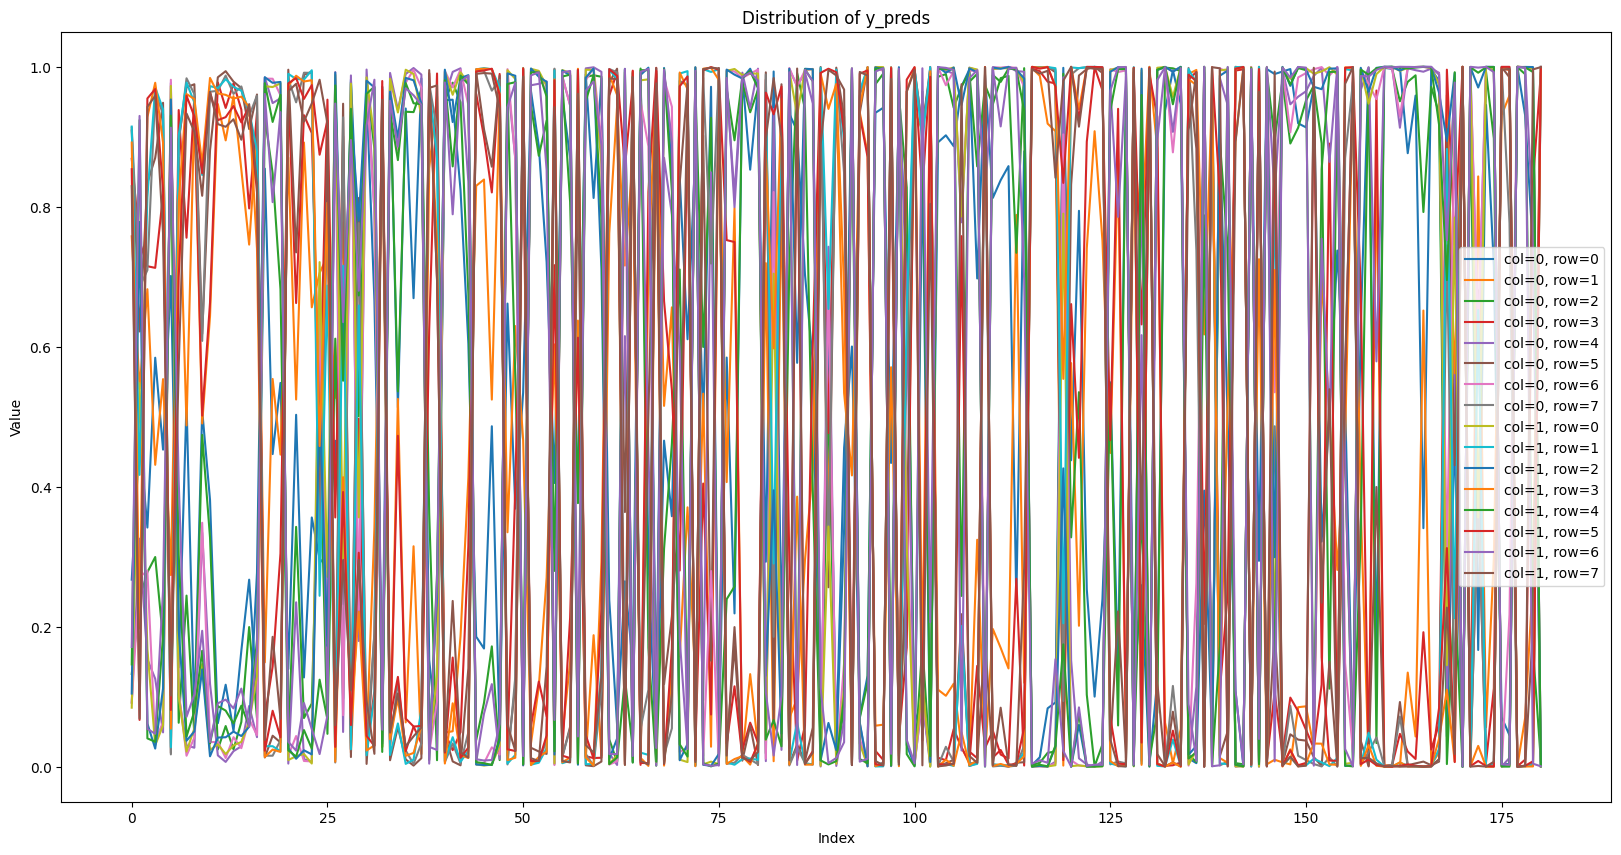

In [11]:
import matplotlib.pyplot as plt

# Plot the distribution of each column in y_preds
plt.figure(figsize=(20, 10))
for col in range(y_preds.shape[1]):
    for row in range(y_preds.shape[2]):
        plt.plot(y_preds[:, col, row], label=f'col={col}, row={row}')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Distribution of y_preds')
plt.legend()
plt.show()


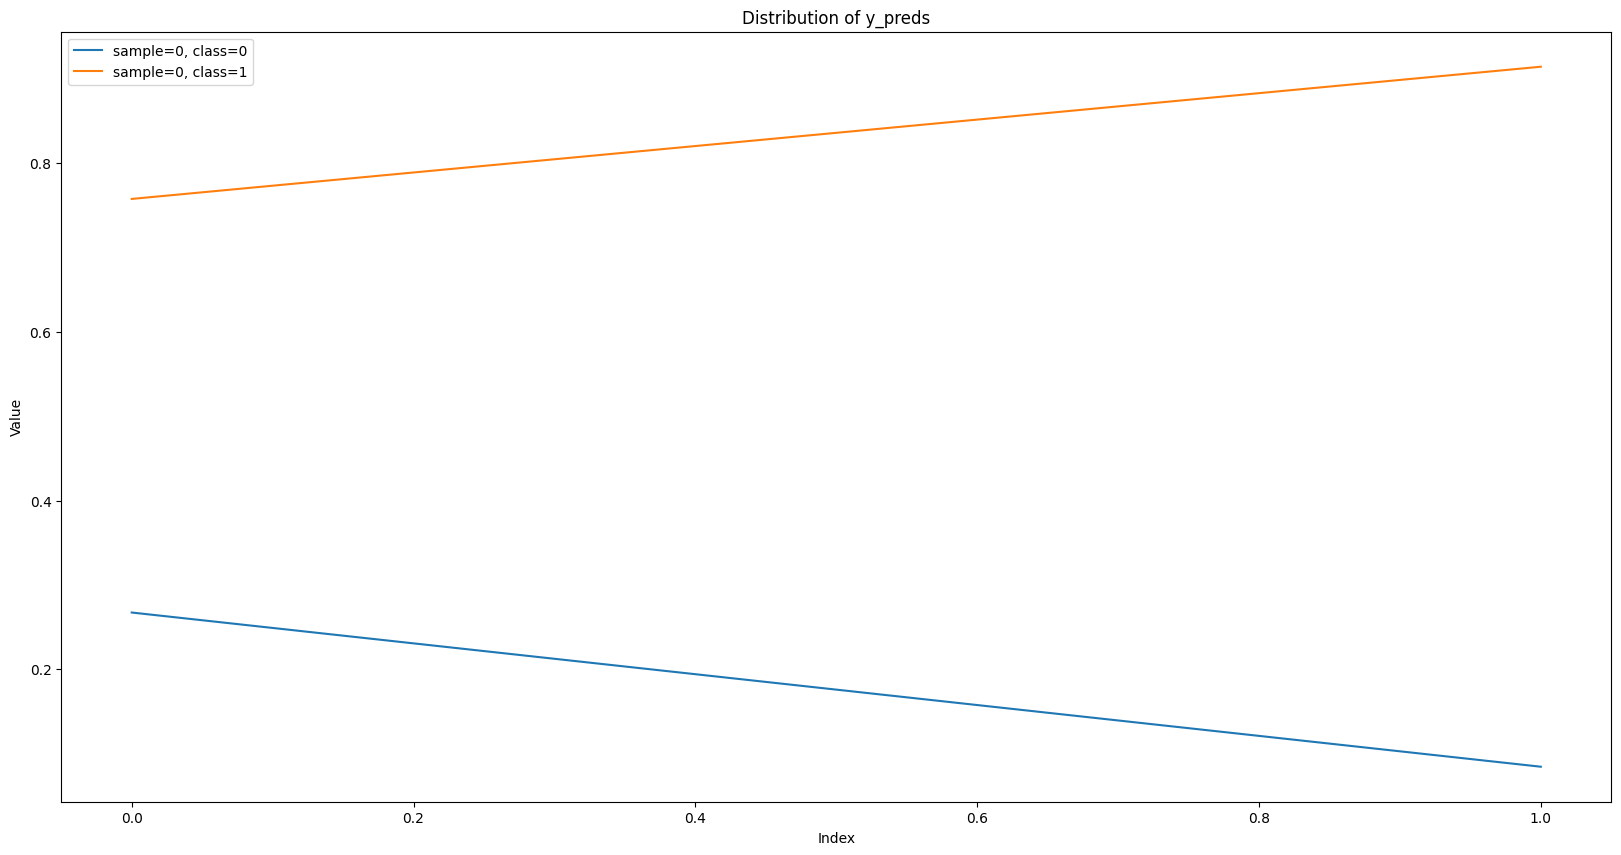

In [12]:
import matplotlib.pyplot as plt

# Plot the distribution of each column in y_preds
plt.figure(figsize=(20, 10))
# for col in range(y_preds.shape[0]):
#     for row in range(y_preds.shape[2]):
for col in range(1):
    for row in range(2):
        plt.plot(y_preds[col, :, row], label=f'sample={col}, class={row}')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Distribution of y_preds')
plt.legend()
plt.show()


In [13]:
y_preds.shape

torch.Size([181, 2, 8])

In [14]:
params['filter'] = 10

In [15]:
postprocessor = Postprocesser()

X_train, X_test, X_newest, y_train, y_test, y_preds = \
    postprocessor.check_shape(X_train, X_test, X_newest, y_train, y_test, y_preds, reshape=params['model_params'][params['model_type']]['reshape'])
test_trade_signals = postprocessor.process_signals(y_test, test_dates, False)
pred_trade_signals = postprocessor.process_signals(y_preds, test_dates, params['filter'])


AttributeError: 'Tensor' object has no attribute 'copy'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix
import seaborn as sns
import backtrader as bt
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from io import StringIO
import sys
from pytorchsummary import summary

class Evaluator:
    def __init__(self, params):
        self.params = params
        pass

    def confusion_matrix(self, y_preds, y_test):
        # Flatten the 3D tensors for evaluation
        y_test_flat = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
        y_preds_flat = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)

        # Calculate evaluation metrics
        precision = precision_score(y_test_flat, y_preds_flat, average='macro')
        recall = recall_score(y_test_flat, y_preds_flat, average='macro')
        accuracy = accuracy_score(y_test_flat, y_preds_flat)
        f1 = f1_score(y_test_flat, y_preds_flat, average='macro')

        return precision, recall, accuracy, f1
    
    def plot_confusion_matrix(self, y_test, y_preds, save_path='plots/confusion_matrix.png'):
        # Convert to class labels if necessary
        y_test = np.argmax(y_test.reshape(-1, y_test.shape[-1]), axis=1)
        y_preds = np.argmax(y_preds.reshape(-1, y_preds.shape[-1]), axis=1)

        # Compute confusion matrix
        cm = confusion_matrix(y_test, y_preds)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title('Confusion Matrix')

        # Calculate metrics
        precision = precision_score(y_test, y_preds, average='macro')
        recall = recall_score(y_test, y_preds, average='macro')
        accuracy = accuracy_score(y_test, y_preds)
        f1 = f1_score(y_test, y_preds, average='macro')

        # Annotate metrics on the plot
        plt.xlabel(f'Predicted\n\nAccuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nPrecision: {precision:.2f}')
        plt.ylabel(f'Actual\n\nRecall: {recall:.2f}')
        plt.savefig(save_path)
        # plt.close()
        plt.show()
        confusion_matrix_text = \
        f'''\nAccuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}\n
        '''
        return save_path, confusion_matrix_text

    def plot_training_curve(self, history, save_path='plots/training_curve.png'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot loss and validation loss
        ax1.plot(history['loss'], label='Loss')
        ax1.plot(history['val_loss'], label='Validation Loss')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        ax1.legend()

        # Plot accuracy and validation accuracy
        ax2.plot(history['binary_accuracy'], label='Accuracy')
        ax2.plot(history['val_binary_accuracy'], label='Validation Accuracy')
        ax2.set_title('Training Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True)
        ax2.legend()
        plt.tight_layout()
        plt.show()
        # Adjust the layout and display the plot
        plt.tight_layout()
        plt.savefig(save_path)
        # plt.close()
        plt.show()

        return save_path

    def plot_online_training_curve(self, acc, losses, save_path='plots/online_training_curve.png'):
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot loss on the second subplot
        ax1.plot(losses, color='tab:blue')
        ax1.set_title('Online Training Loss')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        
        # Plot accuracy on the first subplot
        ax2.plot(acc, color='tab:red')
        ax2.set_title('Online Training Accuracy')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Accuracy')
        ax2.grid(True)

        # Adjust the layout
        plt.tight_layout()
        plt.savefig(save_path)
        # plt.close()
        plt.show()

        return save_path
    
    def remove_short_sequences(self, arr, x):
        """
        Remove sequences in the array that are shorter than x, considering both 0 to 1 and 1 to 0 changes.

        :param arr: The input array
        :param x: The minimum sequence length to keep
        :return: The modified array
        """
        # Identify the changes in the array
        change_indices = np.where(np.diff(arr) != 0)[0] + 1
        # Include the start and end of the array
        change_indices = np.insert(change_indices, 0, 0)
        change_indices = np.append(change_indices, len(arr))
        
        for i in range(len(change_indices) - 1):
            # Calculate the length of the sequence
            seq_length = change_indices[i+1] - change_indices[i]
            if seq_length < x:
                # Set the values of short sequences to the value preceding the sequence
                arr[change_indices[i]:change_indices[i+1]] = arr[change_indices[i] - 1]
        return arr
    
    def plot_predictions(self, y_test, y_preds, filter, save_path='plots/predictions.png'):
        # Convert one-hot encoded arrays to integer labels
        y_test_labels = np.argmax(y_test, axis=-1).flatten()
        y_preds_labels = np.argmax(y_preds, axis=-1).flatten()
        if filter:
            y_preds_labels = self.remove_short_sequences(y_preds_labels.copy(), filter)
        plt.figure(figsize=(32, 6))
        # Plotting y_test
        plt.plot(y_test_labels, label='y_test')

        # Plotting y_preds
        plt.plot(y_preds_labels, label='y_preds')

        # Adding labels and legend
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend(fontsize=20)
        plt.savefig(save_path)
        # Display the plot
        plt.show()
        return save_path
    
    def plot_trading_signals(self, data, trade_signals, x_start=0, x_stop=-1, save_path='plots/trading_details_kbar.png'):
        stock_data = data[['Open', 'High', 'Low', 'Close']].loc[data.index.isin(trade_signals['Date'])]
        stock_data['pred_signal'] = trade_signals['Signal'].values
    
        fig, ax = plt.subplots(figsize=(32, 6))
        for i in stock_data['pred_signal'].index[x_start:x_stop]:
            self._kbar(stock_data['Open'].loc[i], stock_data['Close'].loc[i], stock_data['High'].loc[i], stock_data['Low'].loc[i], i, ax)

        self._plot_signals(trade_signals, stock_data, x_start, x_stop, ax)
        ax.set_title(f'Trading Details, from {stock_data.index[x_start].date()} to {stock_data.index[x_stop].date()}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.set_xticks(stock_data.index[x_start:x_stop])
        # ax.set_xticklabels(stock_data.index[x_start:x_stop].strftime('%Y-%m-%d'), rotation=30, ha='right', fontsize=6)
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
            label.set_fontsize(6)
        plt.grid()
        plt.legend()
        plt.savefig(save_path)
        # plt.close()
        plt.show()

        return save_path

    def _kbar(self, open, close, high, low, pos, ax): # for US stocks
        if close > open: 
            color='green'   # rise               
            height=close - open   
            bottom=open             
        else:                         
            color='red'     # fall            
            height=open - close   
            bottom=close             
        ax.bar(pos, height=height,bottom=bottom, width=0.6, color=color)
        ax.vlines(pos, high, low, color=color)

    def _plot_signals(self, trade_signals, stock_data, x_start, x_stop, ax):
        buy_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Buy') | (trade_signals['Signal'] == 'Buy (first)')]
        for i in buy_signals['Date']:
            if i in stock_data.index: 
                ax.scatter(i, stock_data.loc[i, 'Low'] - 50, marker='^', color='green', s=100)

        sell_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Sell') | (trade_signals['Signal'] == 'Sell (first)')]
        for i in sell_signals['Date']:
            if i in stock_data.index:
                ax.scatter(i, stock_data.loc[i, 'High'] + 50, marker='v', color='red', s=100)

    def find_closest_date(self, pred_trade_signals, test_trade_signals):
        # Filtering and processing signals
        pred_df_filtered = pred_trade_signals[pred_trade_signals['Signal'].notna() & (pred_trade_signals['Signal'] != '')]
        test_df_filtered = test_trade_signals[test_trade_signals['Signal'].notna() & (test_trade_signals['Signal'] != '')]

        for index in pred_df_filtered.index:
            if '(first)' in pred_df_filtered['Signal'].loc[index] or '(last)' in pred_df_filtered['Signal'].loc[index]:
                pred_df_filtered.loc[index, 'Signal'] = pred_df_filtered['Signal'].loc[index].split()[0]
        for index in test_df_filtered.index:
            if '(first)' in test_df_filtered['Signal'].loc[index] or '(last)' in test_df_filtered['Signal'].loc[index]:
                test_df_filtered.loc[index, 'Signal'] = test_df_filtered['Signal'].loc[index].split()[0]
                
        # Creating a new DataFrame to store the results
        pred_days_difference_results = pred_df_filtered.copy()
        pred_days_difference_results['ClosestDateInTest'] = pd.NaT
        pred_days_difference_results['DaysDifference'] = pd.NA
        
        # Iterating through each row in pred_days_difference_results to find the closest date and days difference
        for index, row in pred_days_difference_results.iterrows():
            signal, pred_date = row['Signal'], row['Date']
            same_signal_df = test_df_filtered[test_df_filtered['Signal'] == signal].copy()

            if not same_signal_df.empty:
                same_signal_df['DateDifference'] = (same_signal_df['Date'] - pred_date)
                closest_date = same_signal_df.loc[same_signal_df['DateDifference'].abs().idxmin()]
                pred_days_difference_results.at[index, 'ClosestDateInTest'] = closest_date['Date']
                pred_days_difference_results.at[index, 'DaysDifference'] = closest_date['DateDifference'].days

        return pred_days_difference_results
    
    def _plot_days_difference_bar_chart(self, pred_days_difference_results, save_path='plots/pred_days_difference_bar_chart.png'):
        # Create bar plot
        plt.figure(figsize=(14, 6))
        plt.bar(range(len(pred_days_difference_results)), pred_days_difference_results['DaysDifference'], color='blue', alpha=0.7)
        plt.title('Bar plot of pred_days_difference_results')
        plt.xlabel('Index')
        plt.ylabel('Difference Value')
        plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.savefig(save_path)
        plt.show()
        return save_path
        
    def perform_backtesting(self, stock_data, trade_signals):
        trade_strategy = self.params['trade_strategy']
        
        buffer = StringIO()
        sys.stdout = buffer

        # Initialize cerebro engine
        cerebro = bt.Cerebro()
        # Create a data feed from stock data
        data_feed = bt.feeds.PandasData(dataname=stock_data)
        # Add data feed to cerebro
        cerebro.adddata(data_feed)
        
        # Define and add strategy
        class SignalStrategy(bt.Strategy):
            def __init__(self):
                # Map dates to signals for quick lookup
                self.signal_dict = \
                    dict((pd.Timestamp(date).to_pydatetime().date(), signal)
                                        for date, signal in zip(trade_signals['Date'], 
                                                                trade_signals['Signal']))

            def log(self, txt, dt=None):
                # Logging function for this strategy
                dt = dt or self.datas[0].datetime.date(0)
                print(f'{dt.isoformat()}, {txt}')

            def next(self):
                # Get the current date
                current_date = self.datas[0].datetime.date(0)
                # Check if there's a signal for this date
                signal = self.signal_dict.get(current_date)
                current_price = self.datas[0].open[0]*1.005

                if trade_strategy == 'single':
                    # Original single share buy/sell logic
                    if signal == 'Buy (first)' or signal == 'Buy (last)':
                        # Buy logic
                        self.buy(size=1)
                        self.log("SINGLE BUY EXECUTED")
                    elif signal == 'Sell (first)' or signal == 'Sell (last)':
                        # Sell logic
                        self.sell(size=1)
                        self.log("SINGLE SELL EXECUTED")
                    elif signal == 'Buy':
                        # Buy logic
                        self.buy(size=2)
                        self.log("DOUBLE BUY EXECUTED")  
                    elif signal == 'Sell':
                        # Sell logic
                        self.sell(size=2)
                        self.log("DOUBLE SELL EXECUTED") 
                        
                elif trade_strategy == 'all':
                    # Buy/Sell as many shares as possible
                    if signal == 'Buy (first)' or signal == 'Buy (last)':
                        cash = self.broker.getcash()
                        size_to_buy = int(cash / current_price)  # Only whole shares
                        # if size_to_buy > 0:
                        self.buy(size=size_to_buy)
                        self.log(f"BUY EXECUTED, size_to_buy:{size_to_buy}, signal:{signal}, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size}")
                    elif signal == 'Sell (first)' or signal == 'Sell (last)':
                        size_to_sell = self.getposition(self.datas[0]).size
                        # if size_to_sell > 0:
                        self.sell(size=size_to_sell)
                        self.log(f"SELL EXECUTED, size_to_sell:{size_to_sell}, signal:{signal}, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size}")
                    elif signal == 'Buy':
                        # size_to_sell = self.getposition(self.datas[0]).size
                        # # if size_to_sell > 0:
                        # self.sell(size=size_to_sell)
                        # self.log(f"SELL EXECUTED, size_to_sell:{size_to_sell}, signal:{signal}, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size}")
                        # size_to_buy = self.getposition(self.datas[0]).size*-1
                        # self.buy(size=size_to_buy)
                        # self.log(f"BUY EXECUTED, size_to_buy:{size_to_buy}, signal:{signal}, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size}")
                        cash = self.broker.getcash()
                        size_to_buy = int(cash / current_price)  # Only whole shares
                        # if size_to_buy > 0:
                        self.buy(size=size_to_buy)
                        self.log(f"BUY EXECUTED, size_to_buy:{size_to_buy}, signal:{signal}, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size}")
                    elif signal == 'Sell':
                        # cash = self.broker.getcash()
                        # size_to_buy = int(cash / current_price)  # Only whole shares
                        # # if size_to_buy > 0:
                        # self.buy(size=size_to_buy)
                        # self.log(f"BUY EXECUTED, size_to_buy:{size_to_buy}, signal:{signal}, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size}")
                        size_to_sell = self.getposition(self.datas[0]).size
                        # if size_to_sell > 0:
                        self.sell(size=size_to_sell)
                        self.log(f"SELL EXECUTED, size_to_sell:{size_to_sell}, signal:{signal}, cash:{self.broker.getcash()}, position:{self.getposition(self.datas[0]).size}")

            def notify_order(self, order):
                if order.status in [order.Completed]:
                    cash = self.broker.getcash()
                    value = self.broker.getvalue()
                    if order.isbuy():
                        self.log(f'BUY EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Commission: {order.executed.comm}, Cash: {cash}, Value: {value}')
                    elif order.issell():
                        self.log(f'SELL EXECUTED, Price: {order.executed.price}, Cost: {order.executed.value}, Commission: {order.executed.comm}, Cash: {cash}, Value: {value}')

        # Add strategy to cerebro
        cerebro.addstrategy(SignalStrategy)
        # Set initial cash, commission, etc.
        cerebro.broker.setcash(10000.0)
        cerebro.broker.setcommission(commission=0.005)
        # You can add more code here to analyze the results
        # Add analyzers to cerebro
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
        cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')
        # Run the backtest
        strategies = cerebro.run()
        backtesting_report = dict()
        # Extracting and displaying results
        strategy = strategies[0]
        backtesting_report['sharpe_ratio'] = strategy.analyzers.sharpe_ratio.get_analysis()
        backtesting_report['drawdown'] = strategy.analyzers.drawdown.get_analysis()
        backtesting_report['trade_analyzer'] = strategy.analyzers.trade_analyzer.get_analysis()
        backtesting_report['final_value'] = cerebro.broker.getvalue()
        backtesting_report['pnl'] = backtesting_report['final_value'] - cerebro.broker.startingcash
        backtesting_report['pnl_pct'] = backtesting_report['pnl'] / cerebro.broker.startingcash * 100.0
        backtesting_report['total_return'] = backtesting_report['final_value'] / cerebro.broker.startingcash

        # Plotting the results
        sys.stdout = sys.__stdout__
        trade_summary = buffer.getvalue()
        buffer.close()
        # img = cerebro.plot(style='candlestick', iplot=False, volume=False, savefig=True)
        # img[0][0].savefig(f'plots/backtesting_kbar.png')
        return strategies, backtesting_report, trade_summary
    
    def generate_model_summary(self, model):
        # Capture the summary output
        # buffer = StringIO()
        # sys.stdout = buffer
        # summary(model=model, input_size=(1, 19, 32))
        # sys.stdout = sys.__stdout__
        # model_summary = buffer.getvalue()
        # buffer.close()
        total = sum([param.nelement() for param in model.parameters()])
        model_summary = f'{model}, \nNumber of parameter: {total}'
        return model_summary

    # TODO:　fix the plot_trading_signals bugs
    def _compile_and_save_report(self, model_summary, training_report, online_training_report, 
                                 confusion_matrix, confusion_matrix_text, 
                                 pred_trade_signals_plot_save_path, test_trade_signals_plot_save_path, predictions_save_path, filtered_predictions_save_path,
                                 pred_days_difference_results, pred_days_difference_bar_chart_save_path, 
                                 backtesting_report, trade_summary, save_path='report.html'):
        display(model_summary)
        display(confusion_matrix_text)
        # Compile the report. This can be done using a HTML generator.
        backtesting_report_table = pd.DataFrame()
        backtesting_report_table['sharpe_ratio'] = [backtesting_report['sharpe_ratio']['sharperatio']]
        # backtesting_report_table['drawdown'] = [backtesting_report['drawdown']['max']['drawdown']]
        backtesting_report_table['initial_value'] = [10000.0]
        backtesting_report_table['final_value'] = [backtesting_report['final_value']]
        backtesting_report_table['total_return'] = [backtesting_report['total_return']]
        backtesting_report_table['final_value'] = [backtesting_report['final_value']]
        display(backtesting_report_table)
        backtesting_report = backtesting_report_table.to_html()
        pred_days_difference_abs_mean = pred_days_difference_results['DaysDifference'].abs().mean()
        pred_days_difference_results = pred_days_difference_results.to_html()
        
        report = f'''
        <html>
            <head>
                <title>Stock Price Prediction Report</title>
            </head>
            <body>
                <h1>Stock Price Prediction Report</h1>
                <h2>Model Summary</h2>
                <pre>{model_summary}</pre>
                <h2>Training Report</h2>
                <img src="{training_report}" />
                <h2>Online Training Report</h2>
                <img src="{online_training_report}" />
                <h2>Confusion Matrix</h2>
                <pre>{confusion_matrix_text}</pre>
                <img src="{confusion_matrix}" />
                <h2>Predictions Compared With Actual Signals</h2>
                <img src="{predictions_save_path}" />
                <h2>Filtered Predictions Compared With Actual Signals</h2>
                <img src="{filtered_predictions_save_path}" />
                <h2>Predict Trading Signals Difference Bar chart</h2>
                <img src="{pred_days_difference_bar_chart_save_path}" />
                <h2>Predict Trading Signals Difference Details</h2>
                <pre>Average Difference: {pred_days_difference_abs_mean}</pre>
                <pre>{pred_days_difference_results}</pre>
                <h2>Predict Trading Details</h2>
                <img src="{pred_trade_signals_plot_save_path}" />
                <h2>Actual Trading Details</h2>
                <img src="{test_trade_signals_plot_save_path}" />
                <h2>Trade Summary</h2>
                <pre>{backtesting_report}</pre>
                <h2>Trade Details</h2>
                <pre>{trade_summary}</pre>
            </body>
        </html>
        '''

        # Save the report to a file
        with open(save_path, 'w') as file:
            file.write(report)

    def generate_report(self, model, y_test, y_preds, history, 
                        online_training_acc, online_training_losses,
                        stock_data, pred_trade_signals, test_trade_signals, x_start=0, x_stop=-1):
        model_summary = self.generate_model_summary(model)
        if history:
            training_report = self.plot_training_curve(history, save_path='plots/training_curve.png')
        else:
            training_report = ''
        online_training_report = self.plot_online_training_curve(online_training_acc, 
                                        online_training_losses, save_path='plots/online_training_curve.png')
        confusion_matrix, confusion_matrix_text = self.plot_confusion_matrix(y_test, y_preds, save_path='plots/confusion_matrix.png')
        predictions_save_path = self.plot_predictions(y_test, y_preds, False, save_path='plots/predictions.png')
        filtered_predictions_save_path = self.plot_predictions(y_test, y_preds, filter=self.params['filter'], save_path='plots/filtered_predictions.png')
        pred_trade_signals_plot_save_path = self.plot_trading_signals(stock_data, pred_trade_signals, x_start, x_stop, save_path='plots/pred_trade_signals_details_kbar.png')
        test_trade_signals_plot_save_path = self.plot_trading_signals(stock_data, test_trade_signals, x_start, x_stop, save_path='plots/test_trade_signals_details_kbar.png')
        pred_days_difference_results = self.find_closest_date(pred_trade_signals, test_trade_signals)
        pred_days_difference_bar_chart_save_path = self._plot_days_difference_bar_chart(pred_days_difference_results, save_path='plots/pred_days_difference_bar_chart.png')
        backtest_results, backtesting_report, trade_summary = self.perform_backtesting(stock_data, pred_trade_signals)
        self._compile_and_save_report(model_summary, training_report, online_training_report, confusion_matrix, 
                                      confusion_matrix_text, pred_trade_signals_plot_save_path, test_trade_signals_plot_save_path, predictions_save_path, filtered_predictions_save_path,
                                      pred_days_difference_results, pred_days_difference_bar_chart_save_path, backtesting_report, trade_summary, save_path='report.html')


In [ ]:
params['trade_strategy'] = 'all'

ModelCNN_LSTM(
  (conv1): Conv1d(33, 6, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(6, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (convs): Sequential(
    (0): Conv1d(33, 6, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LayerNorm((6, 32), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(6, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LayerNorm((8, 16), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(8, 32, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=2, bias=True)
), 
Number of parameter: 6834


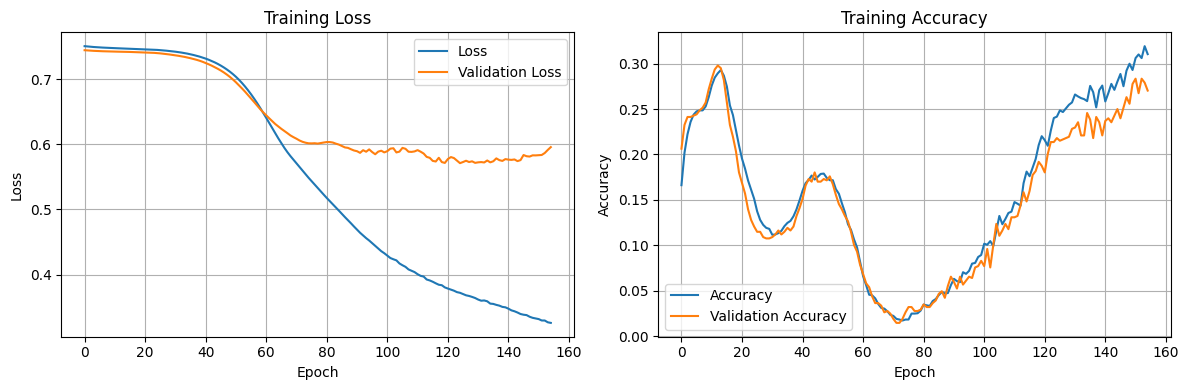

<Figure size 640x480 with 0 Axes>

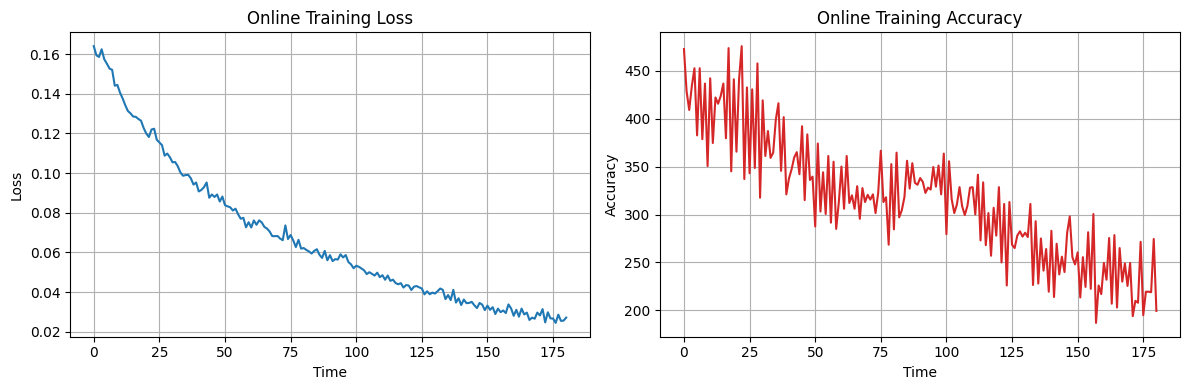

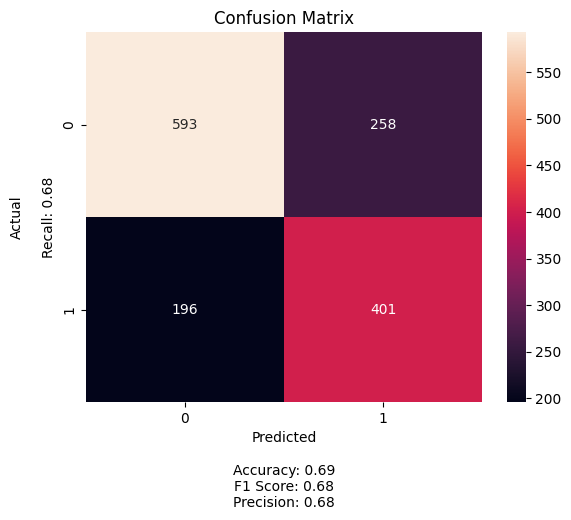

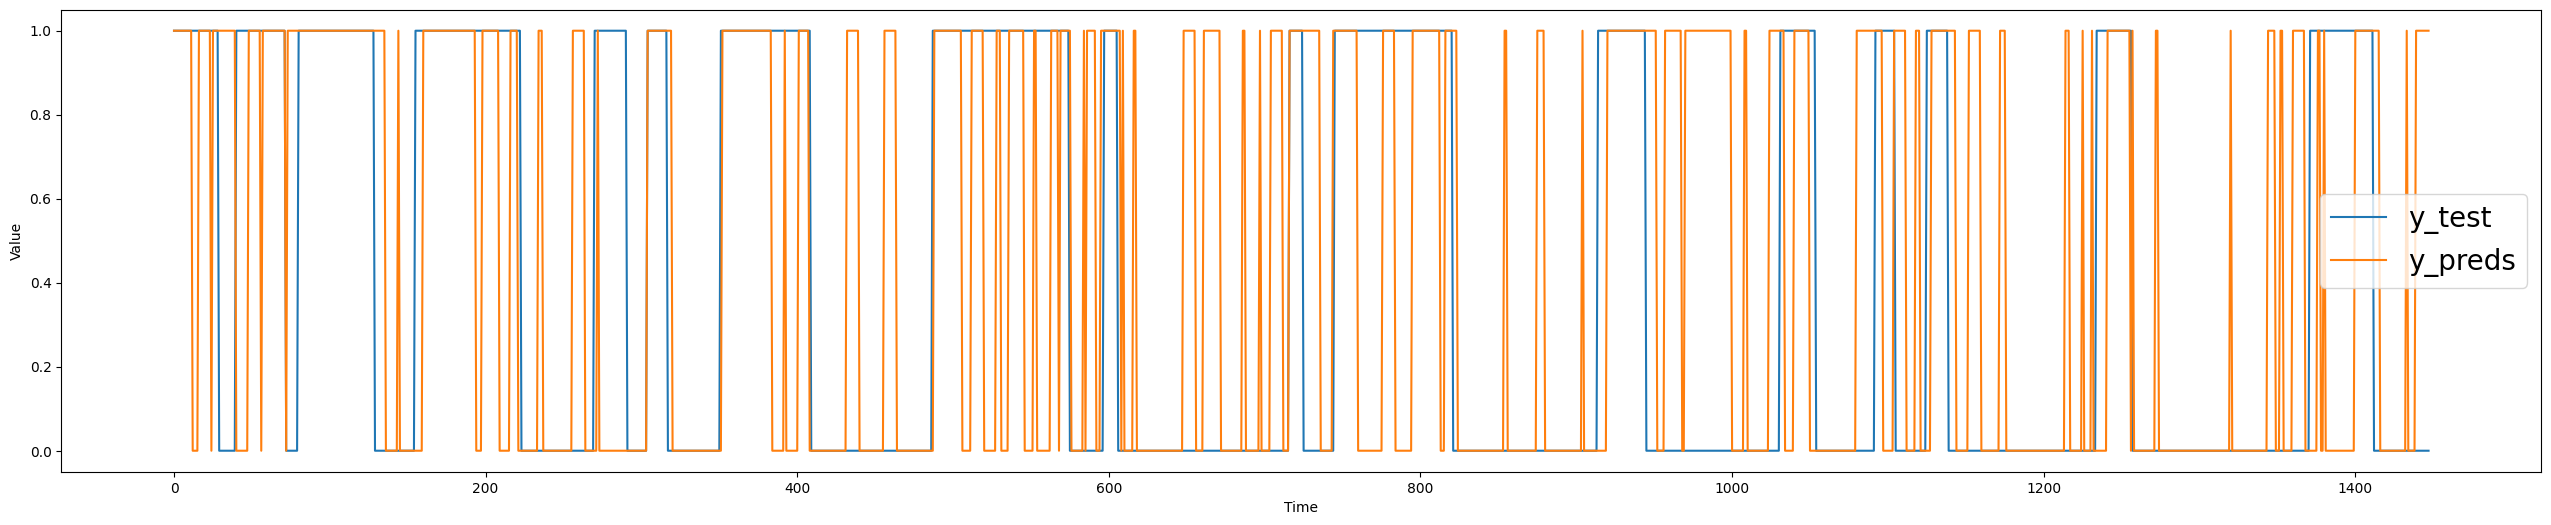

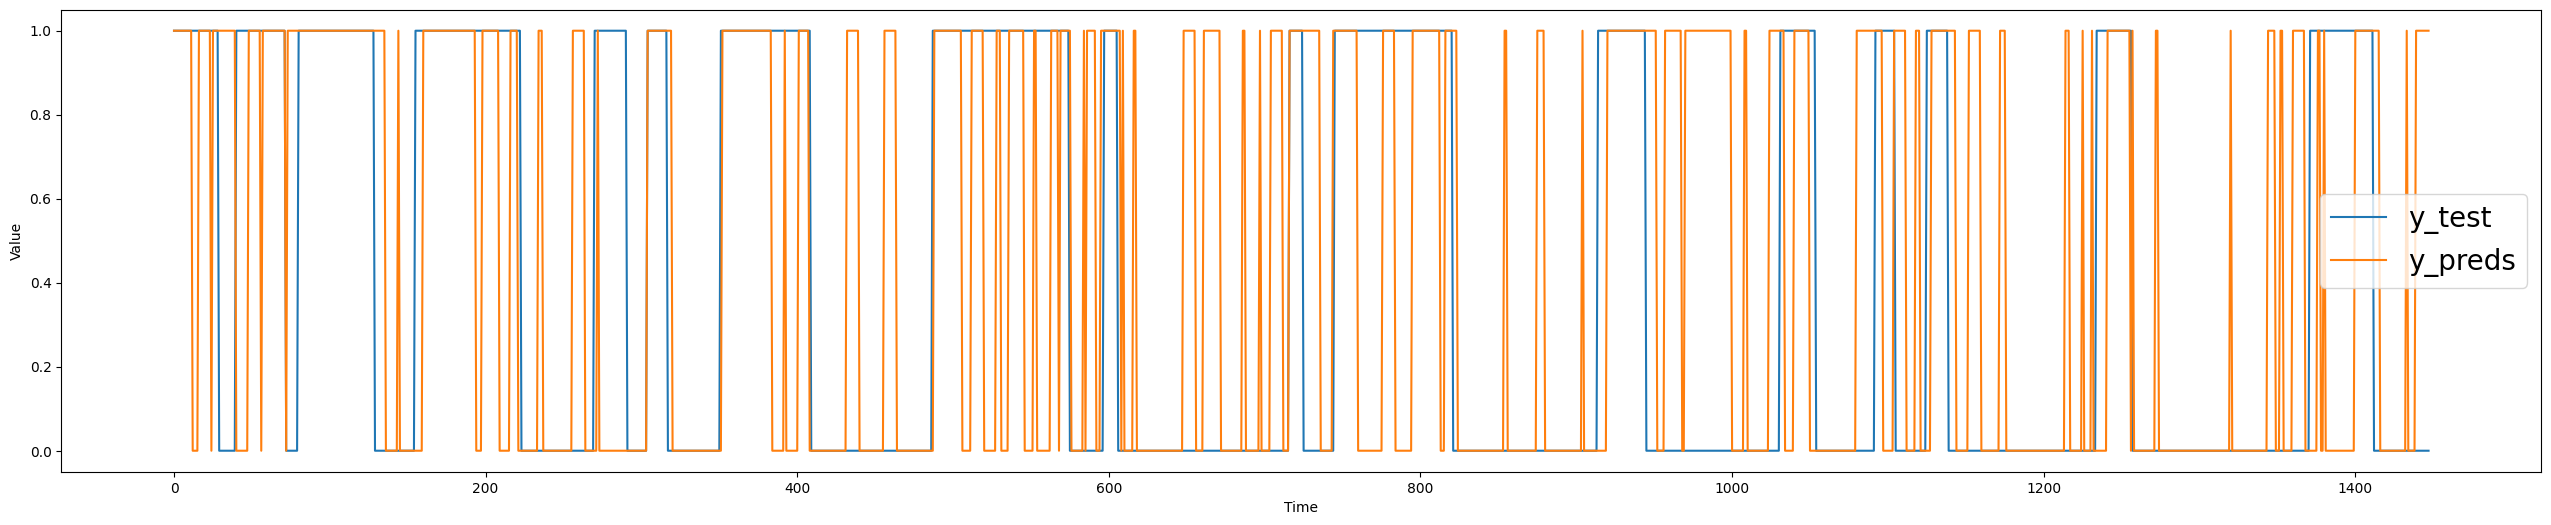

C:\Users\e4903\AppData\Local\Temp\ipykernel_31076\1723497328.py:197: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Buy') | (trade_signals['Signal'] == 'Buy (first)')]
C:\Users\e4903\AppData\Local\Temp\ipykernel_31076\1723497328.py:202: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sell_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Sell') | (trade_signals['Signal'] == 'Sell (first)')]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


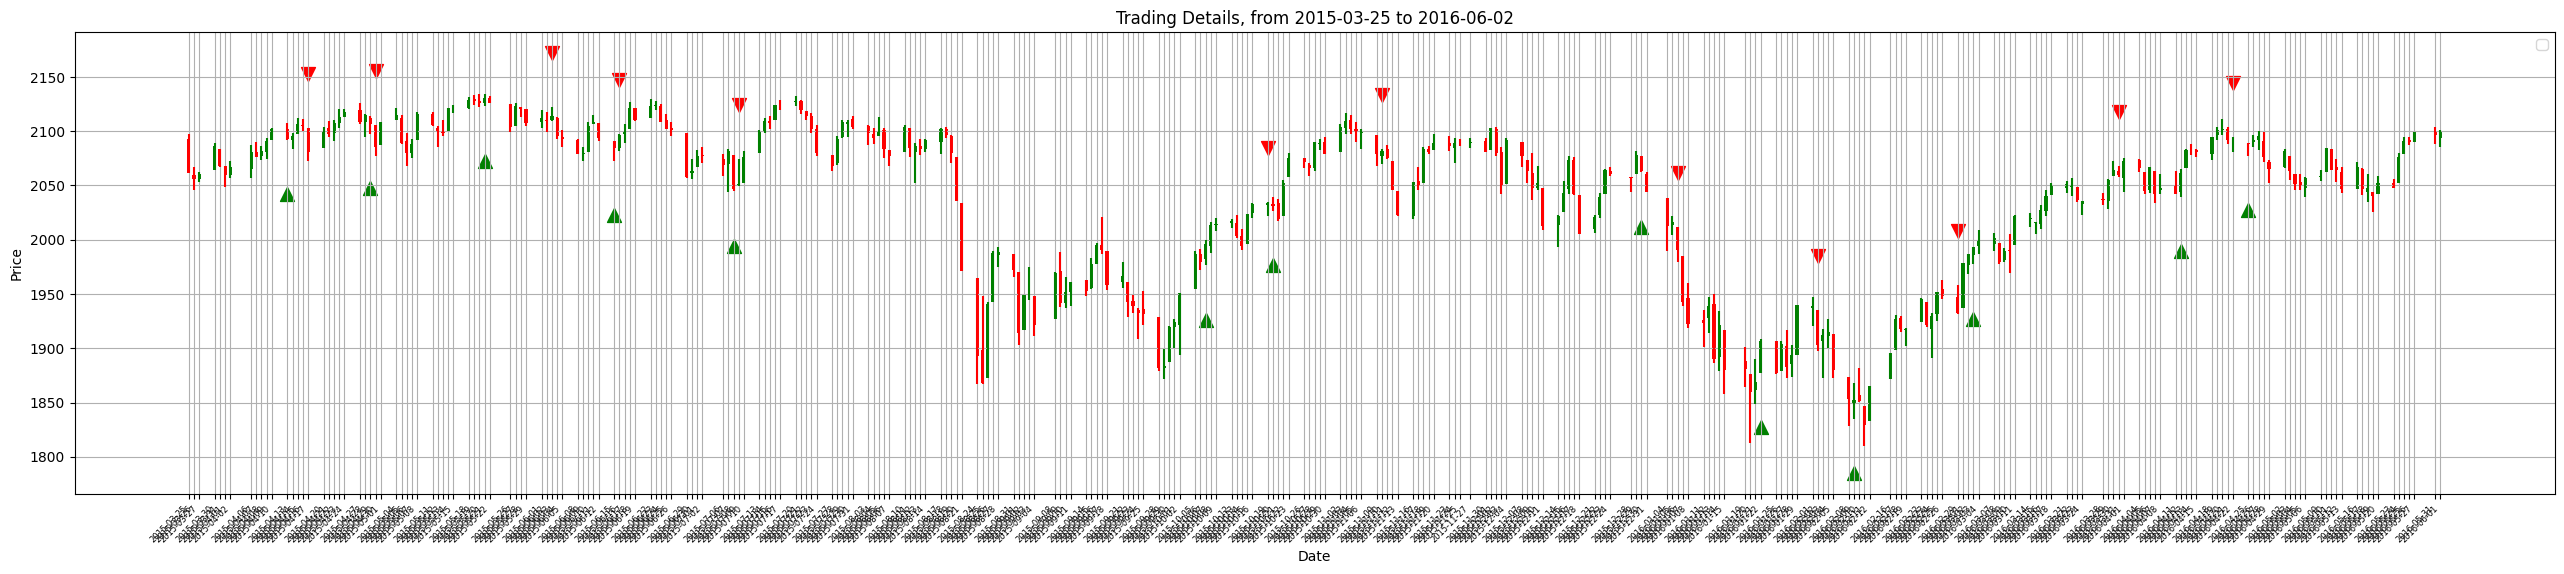

C:\Users\e4903\AppData\Local\Temp\ipykernel_31076\1723497328.py:197: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Buy') | (trade_signals['Signal'] == 'Buy (first)')]
C:\Users\e4903\AppData\Local\Temp\ipykernel_31076\1723497328.py:202: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sell_signals = trade_signals.loc[x_start:x_stop][(trade_signals['Signal'] == 'Sell') | (trade_signals['Signal'] == 'Sell (first)')]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


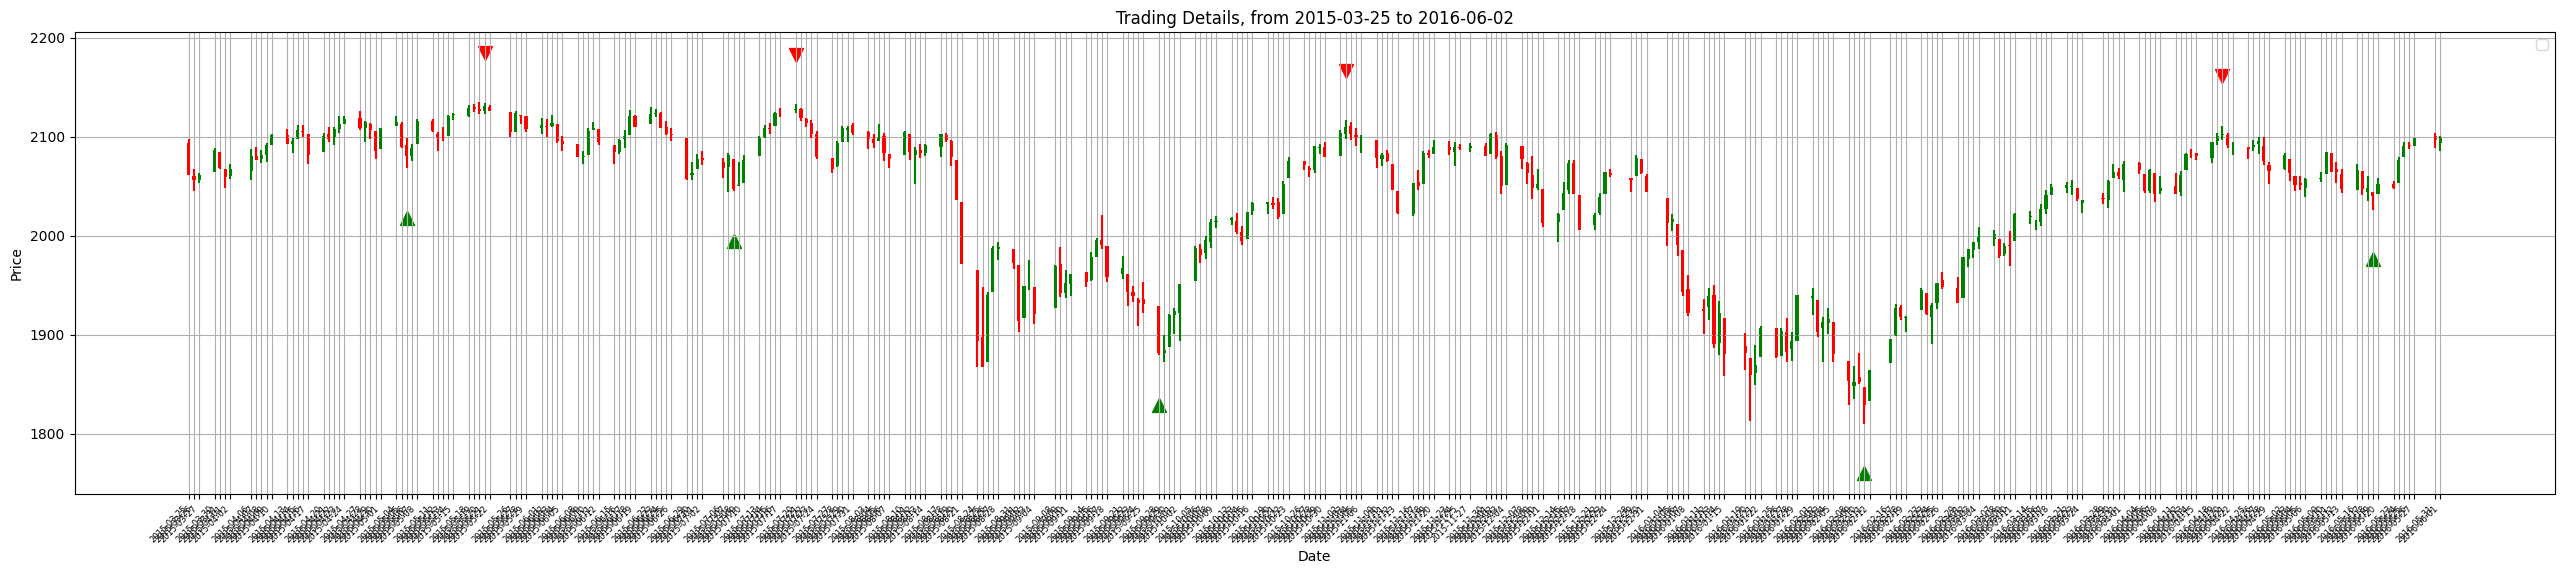

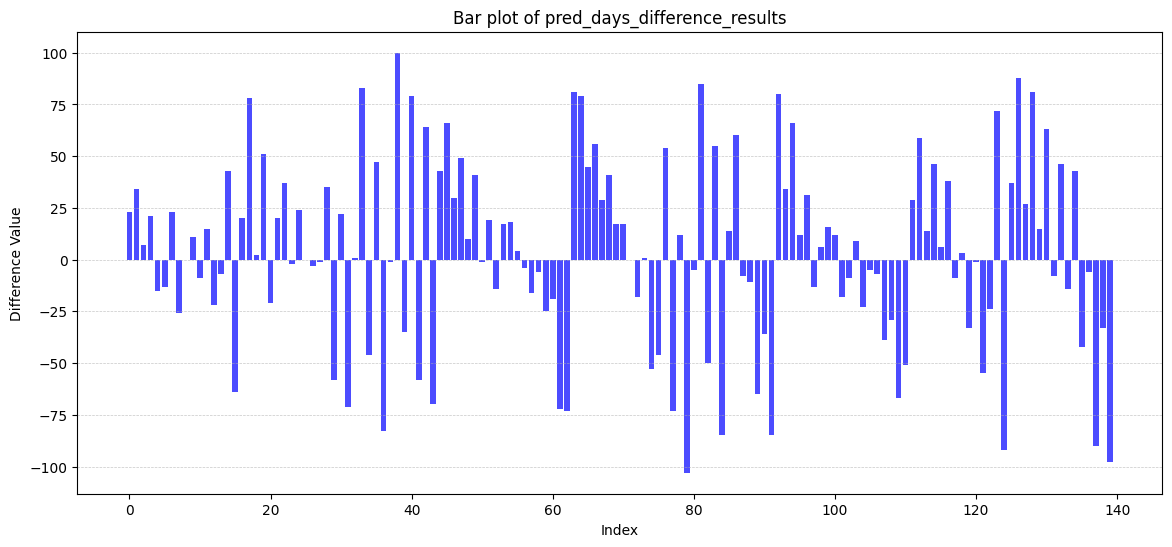

'ModelCNN_LSTM(\n  (conv1): Conv1d(33, 6, kernel_size=(3,), stride=(1,), padding=(1,))\n  (conv2): Conv1d(6, 8, kernel_size=(3,), stride=(1,), padding=(1,))\n  (convs): Sequential(\n    (0): Conv1d(33, 6, kernel_size=(3,), stride=(1,), padding=(1,))\n    (1): LayerNorm((6, 32), eps=1e-05, elementwise_affine=True)\n    (2): ReLU()\n    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n    (4): Conv1d(6, 8, kernel_size=(3,), stride=(1,), padding=(1,))\n    (5): LayerNorm((8, 16), eps=1e-05, elementwise_affine=True)\n    (6): ReLU()\n    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  )\n  (lstm): LSTM(8, 32, batch_first=True, dropout=0.2)\n  (fc): Linear(in_features=32, out_features=2, bias=True)\n), \nNumber of parameter: 6834'

'\nAccuracy: 0.69\nPrecision: 0.68\nRecall: 0.68\nF1 Score: 0.68\n\n        '

,sharpe_ratio,initial_value,final_value,total_return
0,-0.32038,10000.0,10259.344344,1.025934


In [ ]:
evaluator = Evaluator(params=params)
total = sum([param.nelement() for param in model.parameters()])
model_summary = f'{model}, \nNumber of parameter: {total}'
print(model_summary)
evaluator.generate_report(model, y_test, y_preds, history, 
                        online_training_acc, online_training_losses,
                        SP500, pred_trade_signals, test_trade_signals, x_start=0, x_stop=300)
